# AWS SageMaker Inference Inmmersion Day
This notebook shows how to:
* __Lab 1:__ Deploy a real time endpoint with a prebuilt container and invoke it.
* __Lab 2:__ Deploy a real time endpoint with a custom container.
* __Lab 3:__ Host an endpoint with multiple production variants with different traffic.
* __Lab 4:__ Autoscaling your endpoint.
* __Lab 5:__ Host a machine learning model in Amazon SageMaker and capture inference requests, results, and metadata.
* Schedule Clarify bias monitor to monitor predictions for bias drift on a regular basis.
* Schedule Clarify explainability monitor to monitor predictions for feature attribution drift on a regular basis.

## General Setup

To get started, make sure these prerequisites completed.

* Configure SageMaker Studio. Create a sagemaker studio user and an IAM role for that user to use. Role should have: `AmazonSageMakerFullAccess` and `AmazonS3FullAccess` attached. Once configured, follow this instructions: https://sagemaker-immersionday.workshop.aws/en/lab3/option1.html#prerequisites

### Imports

Import APIs to be used by the notebook.

In [1]:
import copy
import json
import random
import time
import boto3
import pandas as pd

from datetime import datetime, timedelta
from sagemaker.session import production_variant
from sagemaker import get_execution_role, image_uris, Session
from sagemaker.serializers import CSVSerializer
from sagemaker.clarify import (
    BiasConfig,
    DataConfig,
    ModelConfig,
    ModelPredictedLabelConfig,
    SHAPConfig,
)
from sagemaker.model import Model
from sagemaker.model_monitor import (
    BiasAnalysisConfig,
    CronExpressionGenerator,
    DataCaptureConfig,
    EndpointInput,
    ExplainabilityAnalysisConfig,
    ModelBiasMonitor,
    ModelExplainabilityMonitor,
)
from sagemaker.s3 import S3Downloader, S3Uploader

### Handful of configuration

In [2]:
role = get_execution_role()
print(f"RoleArn: {role}")

boto_session = boto3.session.Session()

sagemaker_session = Session(boto_session)
sagemaker_client = sagemaker_session.sagemaker_client
sagemaker_runtime_client = sagemaker_session.sagemaker_runtime_client

region = sagemaker_session.boto_region_name
print(f"AWS region: {region}")

RoleArn: arn:aws:iam::396587179375:role/service-role/AmazonSageMaker-ExecutionRole-20211008T164924
AWS region: eu-west-1


In [3]:
# A different bucket can be used, but make sure the role for this notebook has
# the s3:PutObject permissions. This is the bucket into which the data is captured
bucket = sagemaker_session.default_bucket()
print(f"Demo Bucket: {bucket}")
prefix = "sagemaker/DEMO-ClarifyModelMonitor-20200901"
s3_key = f"s3://{bucket}/{prefix}"
print(f"S3 key: {s3_key}")

s3_capture_upload_path = f"{s3_key}/datacapture"
ground_truth_upload_path = f"{s3_key}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
s3_report_path = f"{s3_key}/reports"

print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

baseline_results_uri = f"{s3_key}/baselining"
print(f"Baseline results uri: {baseline_results_uri}")

endpoint_instance_count = 1
endpoint_instance_type = "ml.m5.large"
schedule_expression = CronExpressionGenerator.hourly()

Demo Bucket: sagemaker-eu-west-1-396587179375
S3 key: s3://sagemaker-eu-west-1-396587179375/sagemaker/DEMO-ClarifyModelMonitor-20200901
Capture path: s3://sagemaker-eu-west-1-396587179375/sagemaker/DEMO-ClarifyModelMonitor-20200901/datacapture
Ground truth path: s3://sagemaker-eu-west-1-396587179375/sagemaker/DEMO-ClarifyModelMonitor-20200901/ground_truth_data/2021-10-26-16-30-59
Report path: s3://sagemaker-eu-west-1-396587179375/sagemaker/DEMO-ClarifyModelMonitor-20200901/reports
Baseline results uri: s3://sagemaker-eu-west-1-396587179375/sagemaker/DEMO-ClarifyModelMonitor-20200901/baselining


### Model files and data files

The prebuilt model, and a couple of dataset files.

In [4]:
model_file = "model/xgb-churn-prediction-model.tar.gz"
test_file = "test_data/test-file.txt"
test_dataset = "test_data/test.csv"
validation_dataset = "test_data/validation-dataset-with-header.csv"
dataset_type = "text/csv"

In [5]:
with open(validation_dataset) as f:
    headers_line = f.readline().rstrip()
all_headers = headers_line.split(",")
label_header = all_headers[0]

To verify that the execution role for this notebook has the necessary permissions to proceed. Put a simple test object into the S3 bucket speciﬁed above. If this command fails, update the role to have `s3:PutObject` permission on the bucket and try again.

In [6]:
# Upload a test file
S3Uploader.upload(test_file, f"s3://{bucket}/test_upload", sagemaker_session=sagemaker_session)
print("Success! We are all set to proceed.")

Success! We are all set to proceed.


# LAB 1: Deploying a real-time endpoint on Amazon SageMaker

We are going to create an endpoint using an already trained model with [XGBoost library](https://github.com/dmlc/xgboost). 

## Upload the pre-trained model to Amazon S3
As an example, this code uploads a pre-trained XGBoost model that is ready for to be deployed. This model was trained using the [code that you can find on training folder](../training/xgboost_customer_churn.ipynb) in SageMaker. In order to deploy an endpoint, we will need to first upload the model artifact (the serialized object) to S3.

In [7]:
model_url = S3Uploader.upload(local_path=model_file, desired_s3_uri=s3_key, sagemaker_session=sagemaker_session)
print(f"Model file has been uploaded to {model_url}")

Model file has been uploaded to s3://sagemaker-eu-west-1-396587179375/sagemaker/DEMO-ClarifyModelMonitor-20200901/xgb-churn-prediction-model.tar.gz


## Deploy the model to Amazon SageMaker

Start with deploying a pre-trained churn prediction model. Here, create the SageMaker `Model` object with the image and model data.

In [8]:
model_name = f"DEMO-xgb-churn-pred-model-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Model name: ", model_name)
endpoint_name = f"DEMO-xgb-churn-model-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Endpoint name: ", endpoint_name)

Model name:  DEMO-xgb-churn-pred-model-monitor-2021-10-26-1631
Endpoint name:  DEMO-xgb-churn-model-monitor-2021-10-26-1631


We are going to use an already pre-built docker image with xgboost 0.90-1 version by SageMaker. In order to do this, we will retrieve the ECR docker image URL from Amazon ECR.

In [9]:
image_uri = image_uris.retrieve("xgboost", region, "0.90-1")
print(f"XGBoost image uri: {image_uri}")

XGBoost image uri: 141502667606.dkr.ecr.eu-west-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3


To create the model, we need to pass the mentioned Docker ECR uri, an IAM role used to access the data on S3 and create the endpoint on SageMaker, the model url on S3. Also in order to deploy an endpoint, we will to configure the instance (count and type) and a serializer that will define how the data will be encoded.

In [10]:
model = Model(
    role=role,
    name=model_name,
    image_uri=image_uri,
    model_data=model_url,
    sagemaker_session=sagemaker_session,
)
print(f"Deploying model {model_name} to endpoint {endpoint_name}")
model.deploy(
    initial_instance_count=endpoint_instance_count,
    instance_type=endpoint_instance_type,
    endpoint_name=endpoint_name,
    serializer=CSVSerializer()
)

Deploying model DEMO-xgb-churn-pred-model-monitor-2021-10-26-1631 to endpoint DEMO-xgb-churn-model-monitor-2021-10-26-1631
-----!

## Invoke the endpoint

In [11]:
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait", end="")
test_dataset_size = 0  # record the number of rows in data we're sending for inference
count = 0
with open(test_dataset, "r") as f:
    for row in f:
        if test_dataset_size < 10:
            payload = row.rstrip("\n")
            response = sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                Body=payload[2:],
                ContentType=dataset_type,
            )
            prediction = response["Body"].read()
            print(prediction)
            
            time.sleep(0.5)
        test_dataset_size += 1

print()
print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-model-monitor-2021-10-26-1631. 
Please waitb'0.13533151149749756'
b'0.9820775389671326'
b'0.0010247475001960993'
b'0.004050217568874359'
b'0.3928244113922119'
b'0.9721772074699402'
b'0.9912384152412415'
b'0.7279552221298218'
b'0.8881062269210815'
b'0.9909957051277161'

Done!


# LAB 2: Deploy custom container

## Build and push your docker image to ECR

The following will:
- Create an ECR repository if does not exist.
- Build a docker image and tag it accordingly
- Push the docker image that has been built to the created ECR repo.

In order to do this from SageMaker studio notebook we need to use `sm-docker`. If you want to replicate this running locally, please refer to `sagemaker_inference_immerssion_day` notebook.

In [12]:
!pip install sagemaker-studio-image-build

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [13]:
!cd custom_container && sm-docker build . --repository sagemaker-studio-sklearn-custom:latest

...[Container] 2021/10/26 16:34:15 Waiting for agent ping

[Container] 2021/10/26 16:34:16 Waiting for DOWNLOAD_SOURCE
[Container] 2021/10/26 16:34:18 Phase is DOWNLOAD_SOURCE
[Container] 2021/10/26 16:34:18 CODEBUILD_SRC_DIR=/codebuild/output/src949900643/src
[Container] 2021/10/26 16:34:18 YAML location is /codebuild/output/src949900643/src/buildspec.yml
[Container] 2021/10/26 16:34:18 Processing environment variables
[Container] 2021/10/26 16:34:18 No runtime version selected in buildspec.
[Container] 2021/10/26 16:34:18 Moving to directory /codebuild/output/src949900643/src
[Container] 2021/10/26 16:34:18 Configuring ssm agent with target id: codebuild:bb175e70-2316-4df4-a6f9-ddd41fdf3522
[Container] 2021/10/26 16:34:18 Successfully updated ssm agent configuration
[Container] 2021/10/26 16:34:18 Registering with agent
[Container] 2021/10/26 16:34:18 Phases found in YAML: 3
[Container] 2021/10/26 16:34:18  PRE_BUILD: 9 commands
[Container] 2021/10/26 16:34:18  BUILD: 4 commands
[Con

## Create the endpoint using the custom image

__Note__: Before executing next cells, assign the image uri/repository in the next cell to the `image_uri_custom` variable.

In [14]:
image_uri_custom = "396587179375.dkr.ecr.eu-west-1.amazonaws.com/sagemaker-studio-sklearn-custom:latest"

In [15]:
model_name_custom = f"DEMO-sklearn-churn-predictor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Model name: ", model_name_custom)
endpoint_name_custom = f"DEMO-sklearn-churn-predictor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Endpoint name: ", endpoint_name_custom)

Model name:  DEMO-sklearn-churn-predictor-2021-10-26-1637
Endpoint name:  DEMO-sklearn-churn-predictor-2021-10-26-1637


In [16]:
model = Model(
    role=role,
    name=model_name_custom,
    image_uri=image_uri_custom,
    sagemaker_session=sagemaker_session,
)
print(f"Deploying model {model_name} to endpoint {endpoint_name}")
model.deploy(
    initial_instance_count=endpoint_instance_count,
    instance_type=endpoint_instance_type,
    endpoint_name=endpoint_name_custom
)

Deploying model DEMO-xgb-churn-pred-model-monitor-2021-10-26-1631 to endpoint DEMO-xgb-churn-model-monitor-2021-10-26-1631
-----------!

## Invoke the endpoint

In [17]:
print(f"Sending test traffic to the endpoint {endpoint_name_custom}. \nPlease wait", end="")
test_dataset_size = 0  # record the number of rows in data we're sending for inference
count = 0
with open(test_dataset, "r") as f:
    for row in f:
        if test_dataset_size < 10:
            payload = row.rstrip("\n")
            response = sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name_custom,
                Body=payload[2:],
                ContentType=dataset_type,
            )
            prediction = response["Body"].read()
            print(prediction)
            
            time.sleep(0.5)
        test_dataset_size += 1

print()
print("Done!")

Sending test traffic to the endpoint DEMO-sklearn-churn-predictor-2021-10-26-1637. 
Please waitb'{"pred":0.43654752023796756}\n'
b'{"pred":0.6999476781018328}\n'
b'{"pred":0.24531215932182518}\n'
b'{"pred":0.27046669006375307}\n'
b'{"pred":0.6105907286204117}\n'
b'{"pred":0.7151736608020022}\n'
b'{"pred":0.7457162895871177}\n'
b'{"pred":0.4271587865744501}\n'
b'{"pred":0.6936332582504676}\n'
b'{"pred":0.7437837568170491}\n'

Done!


# LAB 3: Production Variants and A/B Testing

Amazon SageMaker enables you to test multiple models or model versions behind the same endpoint using production variants. Each production variant identifies a machine learning (ML) model and the resources deployed for hosting the model. You can distribute endpoint invocation requests across multiple production variants by providing the traffic distribution for each variant, or you can invoke a specific variant directly for each request.

## Deploy a real-time endpoint with 2 production variants

For this case, we'll be using both models that were already configured in previous steps. Each one is created as a production variant of the endpoint:
- XGBoost Model with 60% of the traffic.
- ScikitLearn Model with 40% left.

In [18]:
production_variants = [
    production_variant(
        model_name=model_name, 
        instance_type=endpoint_instance_type,
        initial_instance_count=endpoint_instance_count,
        initial_weight=0.6,
        variant_name="xgboost-variant"
    ),
    production_variant(
        model_name=model_name_custom,
        instance_type=endpoint_instance_type,
        initial_instance_count=endpoint_instance_count,
        initial_weight=0.4,
        variant_name="sklearn-variant"
    )
]

In [19]:
production_variant_endpoint = sagemaker_session.endpoint_from_production_variants(
    name=f"DEMO-production-variant-endpoint-{datetime.utcnow():%Y-%m-%d-%H%M}",
    production_variants=production_variants,
    wait=True,
)

-------------!

## Invoke the endpoint

In [71]:
# Each endpoint variant will receive a proportion of the calls, defined by the weight. 
# A specific variant can be called by passing the 'TargetVariant' parameter

def invoke_endpoint(payload, **kwargs):
    response = sagemaker_runtime_client.invoke_endpoint(Body=payload, **kwargs)
    prediction = response["Body"].read()
    variant = response['ResponseMetadata']['HTTPHeaders']['x-amzn-invoked-production-variant']
    return prediction, variant

print(f"Sending test traffic to the endpoint {production_variant_endpoint}. \nPlease wait\n", end="")
#params = {'EndpointName':production_variant_endpoint, 'ContentType':dataset_type, 'TargetVariant':"sklearn-variant",} # You can pass the endpoint variant
params = {'EndpointName':production_variant_endpoint, 'ContentType':dataset_type,}
with open(test_dataset, "r") as f:
    for i, row in enumerate(f):
        if i < 15:
            response, variant = invoke_endpoint(row.rstrip("\n")[2:], **params)
            print('Received prediction :' + str(response) + ' from variant ' + variant)
            time.sleep(0.1)


Sending test traffic to the endpoint DEMO-production-variant-endpoint-2021-10-26-1643. 
Please wait
Received prediction :b'0.13533151149749756' from variant xgboost-variant
Received prediction :b'0.9820775389671326' from variant xgboost-variant
Received prediction :b'0.0010247475001960993' from variant xgboost-variant
Received prediction :b'{"pred":0.27046669006375307}\n' from variant sklearn-variant
Received prediction :b'{"pred":0.6105907286204117}\n' from variant sklearn-variant
Received prediction :b'0.9721772074699402' from variant xgboost-variant
Received prediction :b'0.9912384152412415' from variant xgboost-variant
Received prediction :b'0.7279552221298218' from variant xgboost-variant
Received prediction :b'0.8881062269210815' from variant xgboost-variant
Received prediction :b'{"pred":0.7437837568170491}\n' from variant sklearn-variant
Received prediction :b'0.9528167247772217' from variant xgboost-variant
Received prediction :b'0.011917267926037312' from variant xgboost-vari

## A/B Testing

In A/B testing, you test different variants of your models and compare how each variant performs relative to each other. You then choose the best-performing model to replace a previously-existing model new version delivers better performance than the previously-existing version.

In [29]:
# Lets see how often each variant is called.

cw = boto3.Session().client("cloudwatch")

def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        production_variant_endpoint, "xgboost-variant", start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        production_variant_endpoint, "sklearn-variant", start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting a few seconds for initial metric creation...


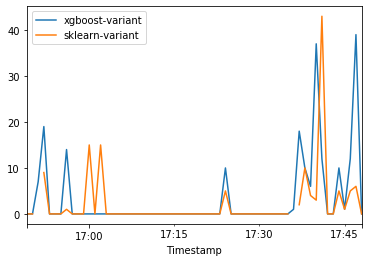

In [67]:
print("Waiting a few seconds for initial metric creation...")
time.sleep(30)
m = plot_endpoint_metrics()

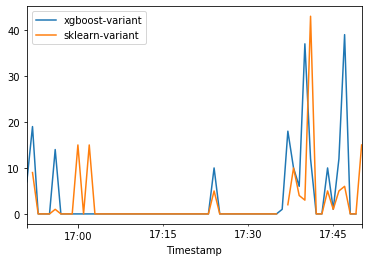

In [69]:
# Make a few calls to a specific variant and re-check the stats

params = {'EndpointName':production_variant_endpoint, 'ContentType':dataset_type, 'TargetVariant':"sklearn-variant",} # You can pass the endpoint variant
with open(test_dataset, "r") as f:
    for i, row in enumerate(f):
        if i < 15:
            response, _ = invoke_endpoint(row.rstrip("\n")[2:], **params)
            time.sleep(0.1)
time.sleep(10)
m = plot_endpoint_metrics()

In [107]:
# Let's evaluate the performance of each endpoint by calling it with test data

params_sklearn = {'EndpointName':production_variant_endpoint, 'ContentType':dataset_type, 'TargetVariant':"sklearn-variant",}
params_xgboost = {'EndpointName':production_variant_endpoint, 'ContentType':dataset_type, 'TargetVariant':"xgboost-variant",}
label = []
predict_sklearn = []
predict_xgboost = []
with open(test_dataset, "r") as f:
    for i, row in enumerate(f):
        if i < 100:
            label.append(int(row.rstrip("\n")[0]))
            response, _ = invoke_endpoint(row.rstrip("\n")[2:], **params_sklearn)
            predict_sklearn.append(round(eval(response)['pred']))
            response, _ = invoke_endpoint(row.rstrip("\n")[2:], **params_xgboost)
            predict_xgboost.append(round(eval(response)))

In [108]:
label = np.array(label)
predict_sklearn = np.array(predict_sklearn)
predict_xgboost = np.array(predict_xgboost)


sklearn_accuracy = sum(predict_sklearn == label) / len(label)
xgboost_accuracy = sum(predict_xgboost == label) / len(label)
print('Accuracy -> sklearn: {}, xgboost: {}'.format(sklearn_accuracy, xgboost_accuracy))

# Calculate precision
sklearn_precision = round(sum(predict_sklearn[predict_sklearn == 1] == label[predict_sklearn == 1]) / len(predict_sklearn[predict_sklearn == 1]), 2)
xgboost_precision = round(sum(predict_xgboost[predict_xgboost == 1] == label[predict_xgboost == 1]) / len(predict_xgboost[predict_xgboost == 1]), 2)
print('Precision -> sklearn: {}, xgboost: {}'.format(sklearn_precision, xgboost_precision))

# Calculate recall
sklearn_recall = round(sum(predict_sklearn[predict_sklearn == 1] == label[predict_sklearn == 1]) / len(label[label == 1]), 2)
xgboost_recall = round(sum(predict_xgboost[predict_xgboost == 1] == label[predict_xgboost == 1]) / len(label[label == 1]), 2)
print('Recall -> sklearn: {}, xgboost: {}'.format(sklearn_recall, xgboost_precision))

# Calculate F1 score
sklearn_f1_score = round(2 * (sklearn_precision * sklearn_recall) / (sklearn_precision + sklearn_recall), 2)
xgboost_f1_score = round(2 * (xgboost_precision * xgboost_recall) / (xgboost_precision + xgboost_recall), 2)
print('F1 Score -> sklearn: {}, xgboost: {}'.format(sklearn_f1_score, xgboost_f1_score))


Accuracy -> sklearn: 0.85, xgboost: 0.97
Precision -> sklearn: 0.82, xgboost: 0.98
Recall -> sklearn: 0.87, xgboost: 0.98
F1 Score -> sklearn: 0.84, xgboost: 0.97


In [110]:
# We see that the xgboost variant is performing better, so lets increase the weight given to this variant

sm = boto3.Session().client("sagemaker")
sm.update_endpoint_weights_and_capacities(
    EndpointName=production_variant_endpoint,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 20, "VariantName": "sklearn-variant"},
        {"DesiredWeight": 80, "VariantName": "xgboost-variant"},
    ],
)

{'EndpointArn': 'arn:aws:sagemaker:eu-west-1:396587179375:endpoint/demo-production-variant-endpoint-2021-10-26-1643',
 'ResponseMetadata': {'RequestId': 'cc75cb57-63af-421b-a559-893518abea8a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'cc75cb57-63af-421b-a559-893518abea8a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '116',
   'date': 'Tue, 26 Oct 2021 18:22:19 GMT'},
  'RetryAttempts': 0}}

In [112]:

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=production_variant_endpoint)["ProductionVariants"]
}

{'xgboost-variant': 0.800000011920929, 'sklearn-variant': 0.20000000298023224}

# LAB 4: Autoscaling your endpoint

Amazon SageMaker supports automatic scaling (autoscaling) for your hosted models. Autoscaling dynamically adjusts the number of instances provisioned for a model in response to changes in your workload. When the workload increases, autoscaling brings more instances online. When the workload decreases, autoscaling removes unnecessary instances so that you don't pay for provisioned instances that you aren't using.

In [ ]:
app_auto_scale_client = boto_session.client("application-autoscaling")

Let's configure autoscaling for the first endpoint from LAB 1.

In [ ]:
resource_id = f"endpoint/{endpoint_name}/variant/AllTraffic"

In [ ]:
app_auto_scale_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=3,
)

In [ ]:
app_auto_scale_client.put_scaling_policy(
    PolicyName='SageMakerSklearnAutoScalePolicy',
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 200,
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': "SageMakerVariantInvocationsPerInstance",
        },
        'DisableScaleIn': False
    }
)

In [ ]:
# References
# https://github.com/awsdocs/amazon-sagemaker-developer-guide/blob/master/doc_source/endpoint-auto-scaling.md
# load testing: https://github.com/awsdocs/amazon-sagemaker-developer-guide/blob/master/doc_source/endpoint-scaling-loadtest.md
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/application-autoscaling.html

# PART E: Capturing real-time inference data from Amazon SageMaker endpoints
Create an endpoint to showcase the data capture capability in action. (In next parts, model monitors will be created to process the data.)



## Background

Amazon SageMaker Model Monitor continuously monitors the quality of Amazon SageMaker machine learning models in production. It enables developers to set alerts for when there are deviations in the model quality. Early and pro-active detection of these deviations enables corrective actions, such as retraining models, auditing upstream systems, or fixing data quality issues without having to monitor models manually or build additional tooling. 

Amazon SageMaker Clarify bias monitoring helps data scientists and ML engineers monitor predictions for bias on a regular basis. One way bias can be introduced in deployed ML models is when the data used in training differs from the data used to generate predictions. This is especially pronounced if the data used for training changes over time (e.g. fluctuating mortgage rates), and the model prediction will not be accurate unless the model is retrained with updated data. For example, model for predicting home prices can be biased if the mortgage rates used to train the model differ from the most current real-world mortgage rate.

Aamazon SageMaker Clarify explainability monitoring offers tools to provide global explanations of models and to explain the predictions of a deployed model producing inferences. Such model explanation tools can help ML modelers and developers and other internal stakeholders understand model characteristics as a whole prior to deployment and to debug predictions provided by the model once deployed. The current offering includes a scalable and efficient implementation of [SHAP](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions), based on the concept of the [Shapley value](https://en.wikipedia.org/wiki/Shapley_value) from the field of cooperative game theory that assigns each feature an importance value for a particular prediction.

As the model is monitored, customers can view exportable reports and graphs detailing bias and feature attributions in SageMaker Studio and configure alerts in Amazon CloudWatch to receive notifications if violations are detected.

#### TODO: Ask Nisha if we can have an SA to help us with definying this part of the example because it's taking too much time as it is.

In [ ]:
model_url = S3Uploader.upload(local_path=model_file, desired_s3_uri=s3_key, sagemaker_session=sagemaker_session)
print(f"Model file has been uploaded to {model_url}")

## Deploy the model to Amazon SageMaker
Start with deploying a pre-trained churn prediction model. Here, create the SageMaker `Model` object with the image and model data.

In [ ]:
model_name = f"DEMO-xgb-churn-pred-model-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Model name: ", model_name)
endpoint_name = f"DEMO-xgb-churn-model-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Endpoint name: ", endpoint_name)

To enable data capture for monitoring jobs, here specify the new capture option called `DataCaptureConfig`, it enables capturing the request payload and the response payload of the endpoint. The capture config applies to all variants. Go ahead with the deployment.

In [ ]:
image_uri = image_uris.retrieve("xgboost", region, "0.90-1")
print(f"XGBoost image uri: {image_uri}")
model = Model(
    role=role,
    name=model_name,
    image_uri=image_uri,
    model_data=model_url,
    sagemaker_session=sagemaker_session,
)

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_upload_path,
)
print(f"Deploying model {model_name} to endpoint {endpoint_name}")
model.deploy(
    initial_instance_count=endpoint_instance_count,
    instance_type=endpoint_instance_type,
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
    serializer=CSVSerializer()
)

## Invoke the deployed model

Now send data to this endpoint to get inferences in real time. Because data capture is enabled in the previous steps, the request and response payload, along with some additional metadata, is saved in the Amazon S3 location specified in the DataCaptureConfig.

In [ ]:
df = pd.read_csv(validation_dataset)
df.head()

In [ ]:
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait", end="")
test_dataset_size = 0  # record the number of rows in data we're sending for inference
count = 0
with open(test_dataset, "r") as f:
    for row in f:
        if test_dataset_size < 120:
            payload = row.rstrip("\n")
            response = sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                Body=payload[2:],
                ContentType=dataset_type,
            )
            prediction = response["Body"].read()
            print(prediction)
            print(".", end="", flush=True)
            
            time.sleep(0.5)
        test_dataset_size += 1

print()
print("Done!")

## View captured data

Now list the data capture files stored in Amazon S3. There should be different files from different time periods organized based on the hour in which the invocation occurred. The format of the Amazon S3 path is:

`s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`

In [ ]:
print("Waiting 30 seconds for captures to show up", end="")
for _ in range(30):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}", sagemaker_session=sagemaker_session))
    if capture_files:
        break
    print(".", end="", flush=True)
    time.sleep(1)
print()
print("Found Capture Files:")
print("\n ".join(capture_files[-5:]))

Next, view the content of a single capture file. Take a quick peek at the first few lines in the captured file.

In [ ]:
capture_file = S3Downloader.read_file(capture_files[-1], sagemaker_session=sagemaker_session).split("\n")[-10:-1]
print(capture_file[-1])

Finally, the contents of a single line is present below in a formatted JSON file to observe a little better.

In [ ]:
print(json.dumps(json.loads(capture_file[-1]), indent=2))

## Start generating some artificial traffic
The cell below starts a thread to send some traffic to the endpoint. If there is no traffic, the monitoring jobs are marked as `Failed` since there is no data to process.

In [ ]:
import threading


class WorkerThread(threading.Thread):
    def __init__(self, do_run, *args, **kwargs):
        super(WorkerThread, self).__init__(*args, **kwargs)
        self.__do_run = do_run
        self.__terminate_event = threading.Event()

    def terminate(self):
        self.__terminate_event.set()

    def run(self):
        while not self.__terminate_event.is_set():
            self.__do_run(self.__terminate_event)

In [ ]:
def invoke_endpoint(terminate_event):
    with open(test_dataset, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload[2:],
                InferenceId=str(i),  # unique ID per row
            )
            i += 1
            response["Body"].read()
            time.sleep(1)
            if terminate_event.is_set():
                break


# Keep invoking the endpoint with test data
invoke_endpoint_thread = WorkerThread(do_run=invoke_endpoint)
invoke_endpoint_thread.start()

Notice the `inferenceId` attribute used above to invoke. If this is present, it will be used to join with ground truth data (otherwise `eventId` will be used):

## Start generating some fake ground truth

Besides captures, model bias monitoring execution also requires ground truth data. In real use cases, ground truth data should be regularly collected and uploaded to designated S3 location. In this example notebook, below code snippet is used to generate fake ground truth data. The first-party merge container will combine captures and ground truth data, and the merged data will be passed to model bias monitoring job for analysis. Similar to captures, the model bias monitoring execution will fail if there's no data to merge.

In [ ]:
def ground_truth_with_id(inference_id):
    random.seed(inference_id)  # to get consistent results
    rand = random.random()
    # format required by the merge container
    return {
        "groundTruthData": {
            "data": "1" if rand < 0.7 else "0",  # randomly generate positive labels 70% of the time
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(upload_time):
    records = [ground_truth_with_id(i) for i in range(test_dataset_size)]
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri, sagemaker_session=sagemaker_session)

In [ ]:
# Generate data for the last hour
upload_ground_truth(datetime.utcnow() - timedelta(hours=1))

In [ ]:
# Generate data once a hour
def generate_fake_ground_truth(terminate_event):
    upload_ground_truth(datetime.utcnow())
    for _ in range(0, 60):
        time.sleep(60)
        if terminate_event.is_set():
            break


ground_truth_thread = WorkerThread(do_run=generate_fake_ground_truth)
ground_truth_thread.start()

# PART B: Model Bias Monitor

Model bias monitor can detect bias drift of Machine Learning models in a regular basis. Similar to the other monitoring types, the standard procedure of creating a model bias monitor is first baselining and then monitoring schedule.

In [ ]:
model_bias_monitor = ModelBiasMonitor(
    role=role,
    sagemaker_session=sagemaker_session,
    max_runtime_in_seconds=1800,
)


## Create a baselining job

A baselining job runs predictions on training dataset and suggests constraints. `suggest_baseline()` method starts a `SageMakerClarifyProcessor` processing job using SageMaker Clarify container to generate the constraints.

The step is not mandatory, but providing constraints file to the monitor can enable violations file generation.

### Configurations

Information about the input data need to be provided to the processor.

`DataConfig` stores information about the dataset to be analyzed, for example the dataset file, its format (CSV or JSONLines), headers (if any) and label.

In [ ]:
model_bias_baselining_job_result_uri = f"{baseline_results_uri}/model_bias"
model_bias_data_config = DataConfig(
    s3_data_input_path=validation_dataset,
    s3_output_path=model_bias_baselining_job_result_uri,
    label=label_header,
    headers=all_headers,
    dataset_type=dataset_type,
)

`BiasConfig` is the configuration of the sensitive groups in the dataset. Typically, bias is measured by computing a metric and comparing it across groups. The group of interest is specified using the "facet." For post-training bias, the possitive label should also be taken into account.

In [ ]:
model_bias_config = BiasConfig(
    label_values_or_threshold=[1],
    facet_name="Account Length",
    facet_values_or_threshold=[100],
)

`ModelPredictedLabelConfig` specifies how to extract a predicted label from the model output. This model returns probability that user will churn. Here choose an arbitrary 0.8 cutoff to consider that a customer will churn. For more complicated outputs, there are a few more options, like "label" is the index, name or JSONpath to locate predicted label in endpoint response payload.

In [ ]:
model_predicted_label_config = ModelPredictedLabelConfig(
    probability_threshold=0.8,
)

`ModelConfig` is configuration related to model to be used for inferencing. In order to compute post-training bias metrics, the computation needs to get inferences for the model name provided. To accomplish this, the processing job will use the model to create an ephemeral endpoint (also known as "shadow endpoint"). The processing job will delete the shadow endpoint after the computations are completed. The configuration is also used by explainability monitor.

In [ ]:
model_config = ModelConfig(
    model_name=model_name,
    instance_count=endpoint_instance_count,
    instance_type=endpoint_instance_type,
    content_type=dataset_type,
    accept_type=dataset_type,
)

### Kick off baselining job

In [ ]:
model_bias_monitor.suggest_baseline(
    data_config=model_bias_data_config,
    model_config=model_config,
    
    bias_config=model_bias_config,
    model_predicted_label_config=model_predicted_label_config,
)
print(f"ModelBiasMonitor baselining job: {model_bias_monitor.latest_baselining_job_name}")

Below cell waits until the baselining job is completed and then inspects the suggested constraints. This step can be skipped, because the monitor to be scheduled will automatically pick up baselining job name and wait for it before monitoring execution.

In [ ]:
model_bias_monitor.latest_baselining_job.wait(logs=False)
model_bias_constraints = model_bias_monitor.suggested_constraints()
print()
print(f"ModelBiasMonitor suggested constraints: {model_bias_constraints.file_s3_uri}")
print(S3Downloader.read_file(model_bias_constraints.file_s3_uri, sagemaker_session=sagemaker_session))

## Schedule model bias monitor

With above constraints collected, now call `create_monitoring_schedule()` method to schedule a hourly monitor, to analyze the data with monitoring schedule. If a baselining job has been submitted, then the monitor will automatically pick up analysis configuration from the baselining job. But if the baselining step is skipped, or the capture dataset has different nature than the training dataset, then analysis configuration has to be provided.

`BiasAnalysisConfig` is a subset of the configuration of the baselining job, many options are not needed because,
* Model bias monitor will merge captures and ground truth data and use merged data as dataset. (~~DataConfig~~)
* Captures already include predictions, so there is no need to create shadow endpoint. (~~ModelConfig~~)
* Attributes like probability threshold are provided as part of EndpointInput. (~~ModelPredictedLabelConfig~~)

In [ ]:
model_bias_analysis_config = None
if not model_bias_monitor.latest_baselining_job:
    model_bias_analysis_config = BiasAnalysisConfig(
        model_bias_config,
        headers=all_headers,
        label=label_header,
    )
model_bias_monitor.create_monitoring_schedule(
    analysis_config=model_bias_analysis_config,
    output_s3_uri=s3_report_path,
    endpoint_input=EndpointInput(
        endpoint_name=endpoint_name,
        destination="/opt/ml/processing/input/endpoint",
        start_time_offset="-PT1H",
        end_time_offset="-PT0H",
        probability_threshold_attribute=0.8,
    ),
    ground_truth_input=ground_truth_upload_path,
    schedule_cron_expression=schedule_expression,
)
print(f"Model bias monitoring schedule: {model_bias_monitor.monitoring_schedule_name}")

## Wait for the first execution

The schedule starts jobs at the previously specified intervals. Code below wait util time crosses the hour boundary (in UTC) to see executions kick off.

Note: Even for an hourly schedule, Amazon SageMaker has a buffer period of 20 minutes to schedule executions. The execution might start in anywhere from zero to ~20 minutes from the hour boundary. This is expected and done for load balancing in the backend.

In [ ]:
def wait_for_execution_to_start(model_monitor):
    print(
        "A hourly schedule was created above and it will kick off executions ON the hour (plus 0 - 20 min buffer)."
    )

    print("Waiting for the first execution to happen", end="")
    schedule_desc = model_monitor.describe_schedule()
    while "LastMonitoringExecutionSummary" not in schedule_desc:
        schedule_desc = model_monitor.describe_schedule()
        print(".", end="", flush=True)
        time.sleep(60)
    print()
    print("Done! Execution has been created")

    print("Now waiting for execution to start", end="")
    while schedule_desc["LastMonitoringExecutionSummary"]["MonitoringExecutionStatus"] in "Pending":
        schedule_desc = model_monitor.describe_schedule()
        print(".", end="", flush=True)
        time.sleep(10)

    print()
    print("Done! Execution has started")

In [ ]:
wait_for_execution_to_start(model_bias_monitor)

In real world, a monitoring schedule is supposed to be active all the time. But in this example, it can be stopped to avoid incurring extra charges. A stopped schedule will not trigger further executions, but the ongoing execution will continue. And if needed, the schedule can be restarted by `start_monitoring_schedule()`.

In [ ]:
model_bias_monitor.stop_monitoring_schedule()

## Wait for the execution to finish

In the previous cell, the first execution has started. This section waits for the execution to finish so that its analysis results are available. Here are the possible terminal states and what each of them mean:

* Completed - This means the monitoring execution completed and no issues were found in the violations report.
* CompletedWithViolations - This means the execution completed, but constraint violations were detected.
* Failed - The monitoring execution failed, maybe due to client error (perhaps incorrect role permissions) or infrastructure issues. Further examination of FailureReason and ExitMessage is necessary to identify what exactly happened.
* Stopped - job exceeded max runtime or was manually stopped.

In [ ]:
# Waits for the schedule to have last execution in a terminal status.
def wait_for_execution_to_finish(model_monitor):
    schedule_desc = model_monitor.describe_schedule()
    execution_summary = schedule_desc.get("LastMonitoringExecutionSummary")
    if execution_summary is not None:
        print("Waiting for execution to finish", end="")
        while execution_summary["MonitoringExecutionStatus"] not in [
            "Completed",
            "CompletedWithViolations",
            "Failed",
            "Stopped",
        ]:
            print(".", end="", flush=True)
            time.sleep(60)
            schedule_desc = model_monitor.describe_schedule()
            execution_summary = schedule_desc["LastMonitoringExecutionSummary"]
        print()
        print("Done! Execution has finished")
    else:
        print("Last execution not found")

In [ ]:
wait_for_execution_to_finish(model_bias_monitor)

## Inspect execution results

List the generated reports,

In [ ]:
schedule_desc = model_bias_monitor.describe_schedule()
execution_summary = schedule_desc.get("LastMonitoringExecutionSummary")
if execution_summary and execution_summary["MonitoringExecutionStatus"] in [
    "Completed",
    "CompletedWithViolations",
]:
    last_model_bias_monitor_execution = model_bias_monitor.list_executions()[-1]
    last_model_bias_monitor_execution_report_uri = (
        last_model_bias_monitor_execution.output.destination
    )
    print(f"Report URI: {last_model_bias_monitor_execution_report_uri}")
    last_model_bias_monitor_execution_report_files = sorted(
        S3Downloader.list(last_model_bias_monitor_execution_report_uri, sagemaker_session=sagemaker_session)
    )
    print("Found Report Files:")
    print("\n ".join(last_model_bias_monitor_execution_report_files))
else:
    last_model_bias_monitor_execution = None
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

If there are violations compared to the baseline, they will be listed here.

In [ ]:
if last_model_bias_monitor_execution:
    model_bias_violations = last_model_bias_monitor_execution.constraint_violations()
    if model_bias_violations:
        print(model_bias_violations.body_dict)

The analysis results and CloudWatch metrics are visualized in SageMaker Studio. Select the Endpoints tab, then double click the endpoint to show the UI.

# PART C: Model Explainability Monitor

Model explainability monitor can explain the predictions of a deployed model producing inferences and detect feature attribution drift on a regular basis.

In [ ]:
model_explainability_monitor = ModelExplainabilityMonitor(
    role=role,
    sagemaker_session=sagemaker_session,
    max_runtime_in_seconds=1800,
)

## Create a baselining job

Similary, a baselining job can be scheduled to suggest constraints for model explainability monitor.

### Configuration

In this example, the explainability baselining job shares the test dataset with the bias baselining job, so here it uses the same `DataConfig`, the only difference is the job output URI.

In [ ]:
model_explainability_baselining_job_result_uri = f"{baseline_results_uri}/model_explainability"
model_explainability_data_config = DataConfig(
    s3_data_input_path=validation_dataset,
    s3_output_path=model_explainability_baselining_job_result_uri,
    label=label_header,
    headers=all_headers,
    dataset_type=dataset_type,
)

Currently the Clarify explainer offers a scalable and efficient implementation of SHAP, so the explainability config is `SHAPConfig`, including
* baseline: A list of rows (at least one) or S3 object URI to be used as the baseline dataset in the Kernel SHAP algorithm. The format should be the same as the dataset format. Each row should contain only the feature columns/values and omit the label column/values.
* num_samples: Number of samples to be used in the Kernel SHAP algorithm. This number determines the size of the generated synthetic dataset to compute the SHAP values.
* agg_method: Aggregation method for global SHAP values. Valid values are
  * "mean_abs" (mean of absolute SHAP values for all instances),
  * "median" (median of SHAP values for all instances) and
  * "mean_sq" (mean of squared SHAP values for all instances).
* use_logit: Indicator of whether the logit function is to be applied to the model predictions. Default is False. If "use_logit" is true then the SHAP values will have log-odds units.
* save_local_shap_values (bool): Indicator of whether to save the local SHAP values in the output location. Default is True.

In [ ]:
# Here use the mean value of test dataset as SHAP baseline
test_dataframe = pd.read_csv(test_dataset, header=None)
#
test_dataframe = test_dataframe.iloc[:, 1:]
shap_baseline = [list(test_dataframe.mean())]
shap_config = SHAPConfig(
    baseline=shap_baseline,
    num_samples=100,
    agg_method="mean_abs",
    save_local_shap_values=False,
)

### Kick off baselining job

The same model_config is required, because the explainability baselining job needs to create shadow endpoint to get predictions for generated synthetic dataset.

In [ ]:
model_explainability_monitor.suggest_baseline(
    data_config=model_explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)
print(
    f"ModelExplainabilityMonitor baselining job: {model_explainability_monitor.latest_baselining_job_name}"
)

Wait for baselining job to finish (or skip this cell because the monitor to be scheduled will wait for it anyway).

In [ ]:
model_explainability_monitor.latest_baselining_job.wait(logs=False)
model_explainability_constraints = model_explainability_monitor.suggested_constraints()
print()
print(
    f"ModelExplainabilityMonitor suggested constraints: {model_explainability_constraints.file_s3_uri}"
)
print(S3Downloader.read_file(model_explainability_constraints.file_s3_uri, sagemaker_session=sagemaker_session))

## Schedule model explainability monitor

Call `create_monitoring_schedule()` method to schedule a hourly monitor, to analyze the data with monitoring schedule. If a baselining job has been submitted, then the monitor will automatically pick up analysis configuration from the baselining job. But if the baselining step is skipped, or the capture dataset has different nature than the training dataset, then analysis configuration has to be provided.

`ModelConfig` is required by `ExplainabilityAnalysisConfig` for the same reason as it is required by the baselining job. Note that only features are required for computing feature attribution, so ground truth label should be excluded.

In [ ]:
model_explainability_analysis_config = None
if not model_explainability_monitor.latest_baselining_job:
    # Remove label because only features are required for the analysis
    headers_without_label_header = copy.deepcopy(all_headers)
    headers_without_label_header.remove(label_header)
    model_explainability_analysis_config = ExplainabilityAnalysisConfig(
        explainability_config=shap_config,
        model_config=model_config,
        headers=headers_without_label_header,
    )
model_explainability_monitor.create_monitoring_schedule(
    output_s3_uri=s3_report_path,
    endpoint_input=endpoint_name,
    schedule_cron_expression=schedule_expression,
)

## Wait for execution and inspect analysis results

Once created the schedule is started by default, here wait for the its first execution to start, then stop the schedule to avoid incurring charges.

In [ ]:
wait_for_execution_to_start(model_explainability_monitor)

In [ ]:
model_explainability_monitor.stop_monitoring_schedule()

Wait further for the execution to finish, then inspect its analysis results,

In [ ]:
wait_for_execution_to_finish(model_explainability_monitor)

In [ ]:
schedule_desc = model_explainability_monitor.describe_schedule()
execution_summary = schedule_desc.get("LastMonitoringExecutionSummary")
if execution_summary and execution_summary["MonitoringExecutionStatus"] in [
    "Completed",
    "CompletedWithViolations",
]:
    last_model_explainability_monitor_execution = model_explainability_monitor.list_executions()[-1]
    last_model_explainability_monitor_execution_report_uri = (
        last_model_explainability_monitor_execution.output.destination
    )
    print(f"Report URI: {last_model_explainability_monitor_execution_report_uri}")
    last_model_explainability_monitor_execution_report_files = sorted(
        S3Downloader.list(last_model_explainability_monitor_execution_report_uri, sagemaker_session=sagemaker_session)
    )
    print("Found Report Files:")
    print("\n ".join(last_model_explainability_monitor_execution_report_files))
else:
    last_model_explainability_monitor_execution = None
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

If there are any violations compared to the baseline, they will be listed here.

In [ ]:
if last_model_explainability_monitor_execution:
    model_explainability_violations = (
        last_model_explainability_monitor_execution.constraint_violations()
    )
    if model_explainability_violations:
        print(model_explainability_violations.body_dict)

The analysis results and CloudWatch metrics are visualized in SageMaker Studio. Select the Endpoints tab, then double click the endpoint to show the UI.

# PART D: Cleanup

The endpoint can keep running and capturing data, but if there is no plan to collect more data or use this endpoint further, it should be deleted to avoid incurring additional charges. Note that deleting endpoint does not delete the data that was captured during the model invocations.

First stop the worker threads,

In [ ]:
invoke_endpoint_thread.terminate()
ground_truth_thread.terminate()

Then stop all monitors scheduled for the endpoint

In [ ]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name, sagemaker_session=sagemaker_session)
model_monitors = predictor.list_monitors()
for model_monitor in model_monitors:
    model_monitor.stop_monitoring_schedule()
    wait_for_execution_to_finish(model_monitor)
    model_monitor.delete_monitoring_schedule()

Finally delete the endpoint

In [ ]:
predictor.delete_endpoint()
predictor.delete_model()